## 1. Imports

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, \
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, \
                             accuracy_score)
import cv2
import scipy

## 2. Importing data and preprocessing
## 2.1. Image Iterator

In [2]:
train_data_gen  = ImageDataGenerator(
                                    rescale=1 / 255.0,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split=0.2,
                                    fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1 / 255.0)

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
train_df = train_data_gen.flow_from_directory  (
    "./dermnet/train",
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode= "categorical",
    subset='training',
    seed=42
)

validation_df = train_data_gen.flow_from_directory  (
    "./dermnet/train",
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode= "categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

test_df = test_data_gen.flow_from_directory(
    "./dermnet/test",
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = 1,
    class_mode='categorical',
    shuffle=False,  
)

Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


In [4]:
classes = train_df.class_names
classes

AttributeError: 'DirectoryIterator' object has no attribute 'class_names'

In [ ]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in train_df.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]],fontsize = 8)
        plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 1500x1500 with 0 Axes>

## 2.2. Creating Partitions (Train/Val)

In [5]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.2,shuffle = True,shuffle_size = 10000):
  assert(train_split+val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  return train_ds, val_ds

In [6]:
train_ds, val_ds = get_dataset_partitions_tf(train_df)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## 2.3. Data Augmentation

In [8]:
resize_and_rescale = tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255),
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## 3.1 Model Training

In [10]:
model = models.Sequential([
                           resize_and_rescale,
                           layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3) ),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)), 
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)),    
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),    
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(23, activation='softmax')
])
model.build(input_shape = (BATCH_SIZE,128,128,3))


In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 126, 126, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 63, 63, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 61, 61, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 30, 30, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 28, 28, 128)        

In [12]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
EPOCHS = 100
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
) 

Epoch 1/100
195/195 [==============================] - 40s 105ms/step - loss: 2.9761 - accuracy: 0.0933 - val_loss: 2.8988 - val_accuracy: 0.1361
Epoch 2/100
195/195 [==============================] - 19s 100ms/step - loss: 2.8713 - accuracy: 0.1489 - val_loss: 2.8687 - val_accuracy: 0.1458
Epoch 3/100
195/195 [==============================] - 19s 96ms/step - loss: 2.8196 - accuracy: 0.1625 - val_loss: 2.7819 - val_accuracy: 0.1726
Epoch 4/100
195/195 [==============================] - 20s 103ms/step - loss: 2.7707 - accuracy: 0.1774 - val_loss: 2.7490 - val_accuracy: 0.1865
Epoch 5/100
195/195 [==============================] - 19s 99ms/step - loss: 2.7286 - accuracy: 0.1864 - val_loss: 2.7251 - val_accuracy: 0.1885
Epoch 6/100
195/195 [==============================] - 19s 99ms/step - loss: 2.6929 - accuracy: 0.1992 - val_loss: 2.6669 - val_accuracy: 0.2048
Epoch 7/100
195/195 [==============================] - 19s 99ms/step - loss: 2.6666 - accuracy: 0.2035 - val_loss: 2.6754 - val

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

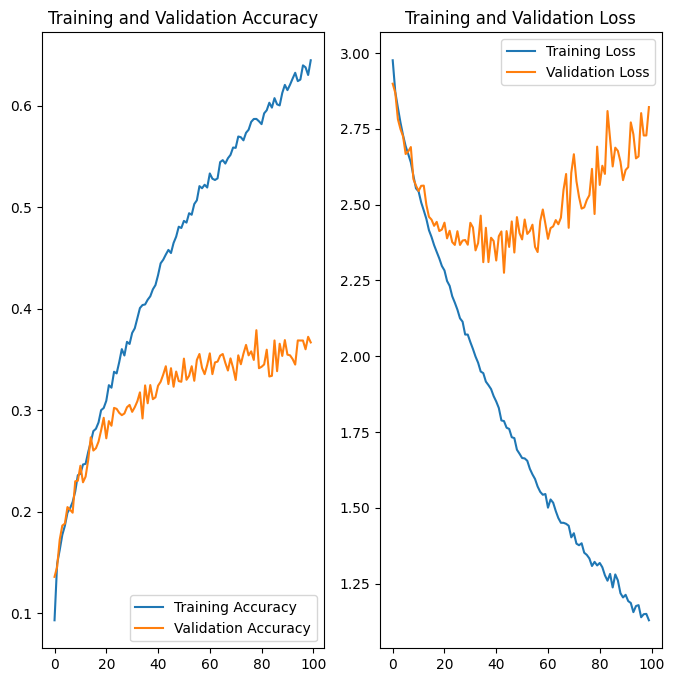

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
model.save("./model/build")

INFO:tensorflow:Assets written to: ./model/build\assets


INFO:tensorflow:Assets written to: ./model/build\assets


## Using Inception V3

In [49]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [51]:
pre_trained_model = InceptionV3(input_shape=(128, 128, 3), 
                                include_top = False, weights = 'imagenet')

In [52]:
# Freezing the layers
for layers in pre_trained_model.layers:
    layers.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE)(inputs)
x = layers.experimental.preprocessing.Rescaling(1.0/255)()
x = pre_trained_model()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(23, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [53]:
# Adding last layers
x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(23, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

AttributeError: 'Concatenate' object has no attribute 'experimental'

In [18]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
) 

Epoch 1/10
195/195 [==============================] - 32s 97ms/step - loss: 5.8309 - accuracy: 0.0794 - val_loss: 3.1633 - val_accuracy: 0.0892
Epoch 2/10
195/195 [==============================] - 18s 92ms/step - loss: 3.1390 - accuracy: 0.0894 - val_loss: 3.1263 - val_accuracy: 0.0814
Epoch 3/10
195/195 [==============================] - 18s 90ms/step - loss: 3.1292 - accuracy: 0.0907 - val_loss: 3.1161 - val_accuracy: 0.0919
Epoch 4/10
195/195 [==============================] - 17s 89ms/step - loss: 3.1174 - accuracy: 0.0903 - val_loss: 3.1107 - val_accuracy: 0.0939
Epoch 5/10
195/195 [==============================] - 18s 90ms/step - loss: 3.1096 - accuracy: 0.0903 - val_loss: 3.1054 - val_accuracy: 0.0944
Epoch 6/10
195/195 [==============================] - 17s 89ms/step - loss: 3.1046 - accuracy: 0.0909 - val_loss: 3.0979 - val_accuracy: 0.0879
Epoch 7/10
195/195 [==============================] - 17s 89ms/step - loss: 3.0968 - accuracy: 0.0907 - val_loss: 3.0944 - val_accuracy:

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

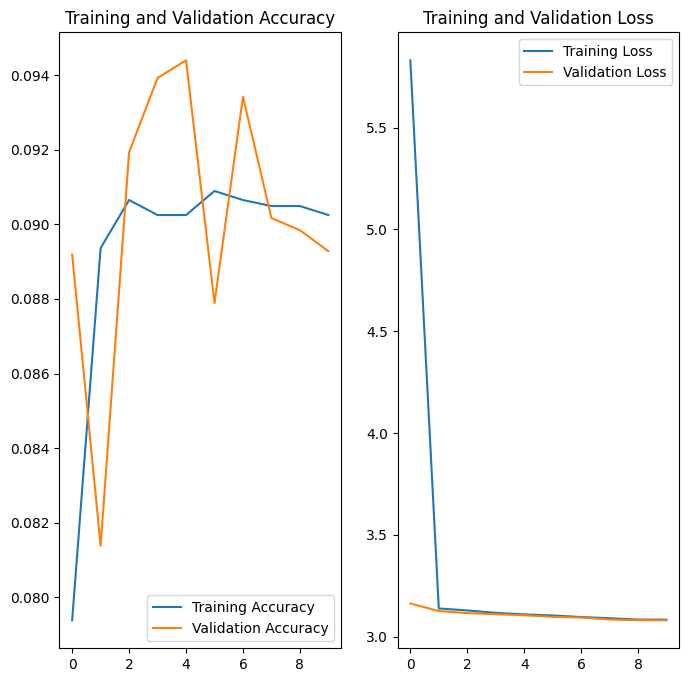

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## VGG

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

In [11]:
pre_trained_model = VGG16(input_shape=(128, 128, 3), 
                                include_top = False, weights = 'imagenet')

In [12]:
# Freezing the layers
for layers in pre_trained_model.layers:
    layers.trainable = False

In [13]:
x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(23, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [17]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
EPOCHS = 250
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
) 

Epoch 1/250
195/195 [==============================] - 36s 123ms/step - loss: 4.9763 - accuracy: 0.1034 - val_loss: 3.1595 - val_accuracy: 0.1094
Epoch 2/250
195/195 [==============================] - 23s 119ms/step - loss: 3.0645 - accuracy: 0.1419 - val_loss: 3.0358 - val_accuracy: 0.1660
Epoch 3/250
195/195 [==============================] - 23s 119ms/step - loss: 2.9814 - accuracy: 0.1624 - val_loss: 3.0063 - val_accuracy: 0.1553
Epoch 4/250
195/195 [==============================] - 23s 118ms/step - loss: 2.9223 - accuracy: 0.1791 - val_loss: 2.9611 - val_accuracy: 0.1713
Epoch 5/250
195/195 [==============================] - 23s 118ms/step - loss: 2.8905 - accuracy: 0.1879 - val_loss: 2.9683 - val_accuracy: 0.1712
Epoch 6/250
195/195 [==============================] - 23s 118ms/step - loss: 2.8437 - accuracy: 0.1974 - val_loss: 2.9486 - val_accuracy: 0.1807
Epoch 7/250
195/195 [==============================] - 23s 118ms/step - loss: 2.8024 - accuracy: 0.2109 - val_loss: 2.9491 -

In [19]:
scores = model.evaluate(test_ds)

63/63 [==============================] - 8s 83ms/step - loss: 11.5922 - accuracy: 0.2464


In [29]:
model = tf.keras.models.load_model('./model/build')

first image to predict
actual label: Herpes HPV and other STDs Photos
2/2 [==============================] - 2s 6ms/step
predicted label: Nail Fungus and other Nail Disease


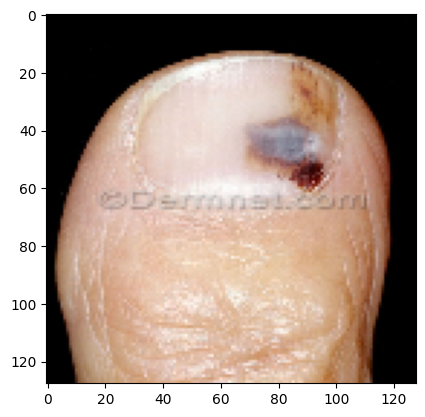

In [20]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[23].numpy().astype('uint8')
    first_label = labels_batch[25].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[23])])

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


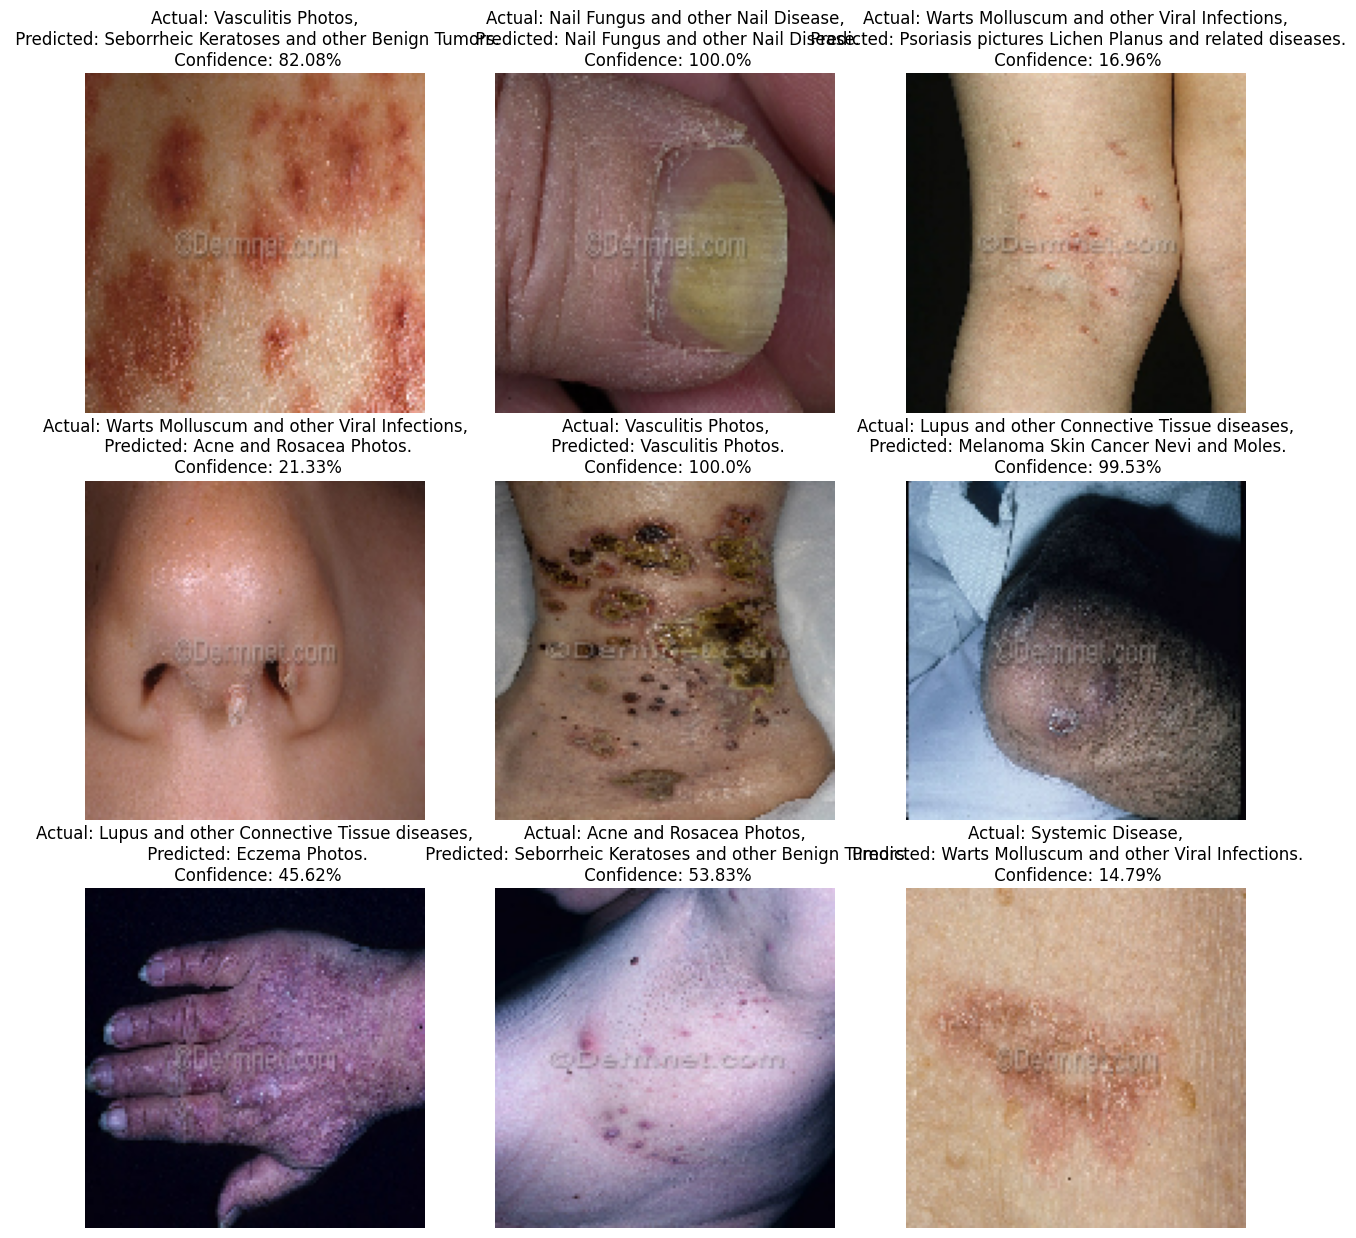

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [23]:
model.save("./model2/build")

INFO:tensorflow:Assets written to: ./model2/build\assets


INFO:tensorflow:Assets written to: ./model2/build\assets


## Mobile Net v2

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [11]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
pre_trained_model = MobileNetV2(input_shape=(128, 128, 3), 
                                include_top = False, weights = 'imagenet', classes=23)

In [13]:
# Freezing the layers
for layers in pre_trained_model.layers:
    layers.trainable = False

In [14]:
# inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# x = resize(x)
# x = rescale(x)
# x = preprocess_input(x)
# x = pre_trained_model(x, training=False)


In [16]:
x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(23, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input , x)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [18]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
EPOCHS = 500
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
)

Epoch 1/500
195/195 [==============================] - 26s 83ms/step - loss: 2.8099 - accuracy: 0.1868 - val_loss: 3.2806 - val_accuracy: 0.0658
Epoch 2/500
195/195 [==============================] - 15s 78ms/step - loss: 2.5623 - accuracy: 0.2537 - val_loss: 3.6934 - val_accuracy: 0.0934
Epoch 3/500
195/195 [==============================] - 15s 78ms/step - loss: 2.4264 - accuracy: 0.2910 - val_loss: 3.7566 - val_accuracy: 0.0899
Epoch 4/500
195/195 [==============================] - 15s 78ms/step - loss: 2.3444 - accuracy: 0.3130 - val_loss: 4.1274 - val_accuracy: 0.0899
Epoch 5/500
195/195 [==============================] - 15s 78ms/step - loss: 2.2574 - accuracy: 0.3331 - val_loss: 4.4463 - val_accuracy: 0.0671
Epoch 6/500
195/195 [==============================] - 15s 78ms/step - loss: 2.1998 - accuracy: 0.3509 - val_loss: 4.8259 - val_accuracy: 0.0755
Epoch 7/500
195/195 [==============================] - 15s 78ms/step - loss: 2.1323 - accuracy: 0.3622 - val_loss: 5.1908 - val_ac

KeyboardInterrupt: 

In [20]:
model.save("./modelMobileNet/build")

INFO:tensorflow:Assets written to: ./modelMobileNet/build\assets


INFO:tensorflow:Assets written to: ./modelMobileNet/build\assets


first image to predict
actual label: Light Diseases and Disorders of Pigmentation
2/2 [==============================] - 1s 202ms/step
predicted label: Tinea Ringworm Candidiasis and other Fungal Infections


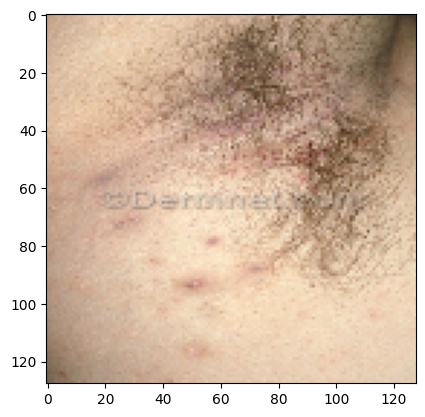

In [24]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[23].numpy().astype('uint8')
    first_label = labels_batch[25].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[23])])

In [18]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


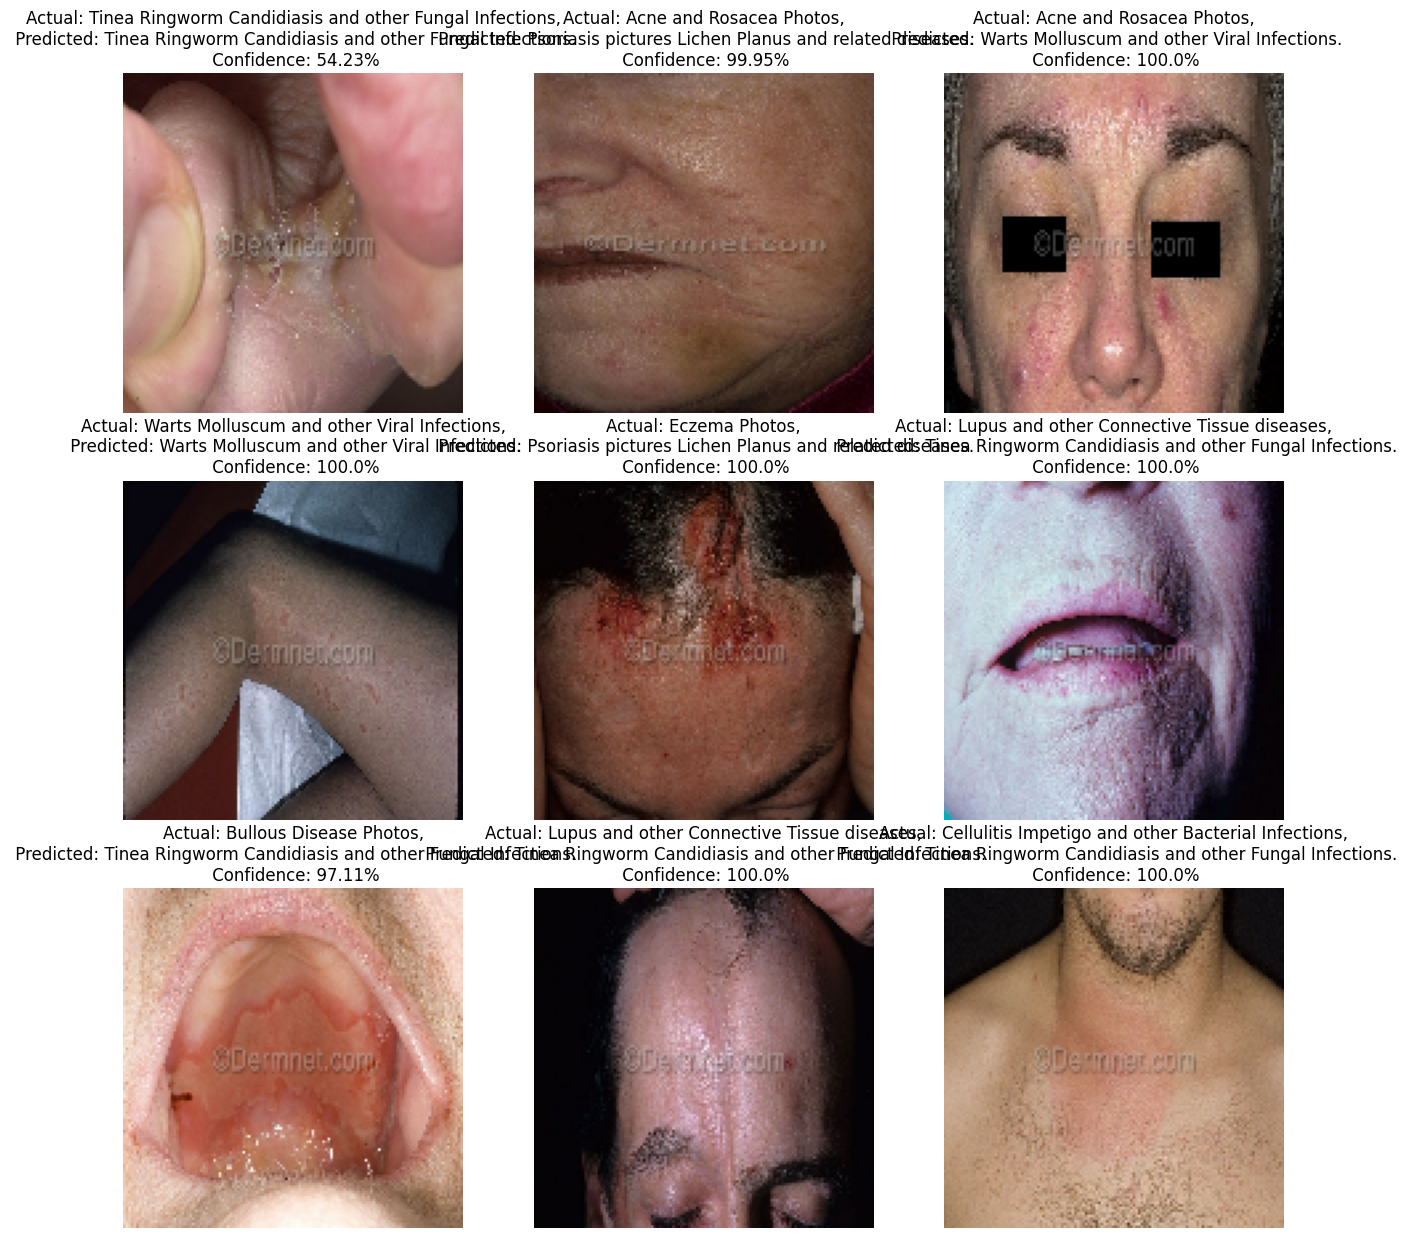

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model(image_batch)
print(feature_batch)

tf.Tensor(
[[0.08207665 0.12745912 0.01777994 ... 0.03637078 0.01224978 0.09187096]
 [0.06509738 0.16214472 0.00998276 ... 0.04212035 0.00875152 0.08222598]
 [0.08080348 0.01514981 0.00886769 ... 0.05097758 0.00522637 0.14612001]
 ...
 [0.06744283 0.16887665 0.01196838 ... 0.03805451 0.00898054 0.08788323]
 [0.31884235 0.0263592  0.04243885 ... 0.00777781 0.01478839 0.0966559 ]
 [0.0058137  0.01241973 0.01540791 ... 0.00491064 0.0034354  0.07788493]], shape=(64, 23), dtype=float32)


## Resnet

In [11]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

In [12]:
pre_trained_model = ResNet152V2(input_shape=(128, 128, 3), 
                                include_top = False, weights = 'imagenet', classes=23)

In [13]:
# Freezing the layers
for layers in pre_trained_model.layers:
    layers.trainable = False

In [14]:
x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(23, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input , x)

In [15]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
EPOCHS = 500
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
)

Epoch 1/500
195/195 [==============================] - 53s 165ms/step - loss: 2.8891 - accuracy: 0.1841 - val_loss: 226.3582 - val_accuracy: 0.1120
Epoch 2/500
195/195 [==============================] - 30s 152ms/step - loss: 2.5949 - accuracy: 0.2468 - val_loss: 495.2200 - val_accuracy: 0.1055
Epoch 3/500
195/195 [==============================] - 30s 153ms/step - loss: 2.4576 - accuracy: 0.2891 - val_loss: 789.3151 - val_accuracy: 0.0860
Epoch 4/500
195/195 [==============================] - 30s 152ms/step - loss: 2.3609 - accuracy: 0.3116 - val_loss: 1442.2303 - val_accuracy: 0.0880
Epoch 5/500
195/195 [==============================] - 30s 153ms/step - loss: 2.2555 - accuracy: 0.3381 - val_loss: 1831.9352 - val_accuracy: 0.0908
Epoch 6/500
195/195 [==============================] - 30s 153ms/step - loss: 2.1888 - accuracy: 0.3615 - val_loss: 2274.1206 - val_accuracy: 0.0885
Epoch 7/500
195/195 [==============================] - 30s 153ms/step - loss: 2.1188 - accuracy: 0.3769 - val

In [17]:
model.save("./modelResNet/build")

INFO:tensorflow:Assets written to: ./modelResNet/build\assets


INFO:tensorflow:Assets written to: ./modelResNet/build\assets


1/1 [==============================] - 0s 39ms/step


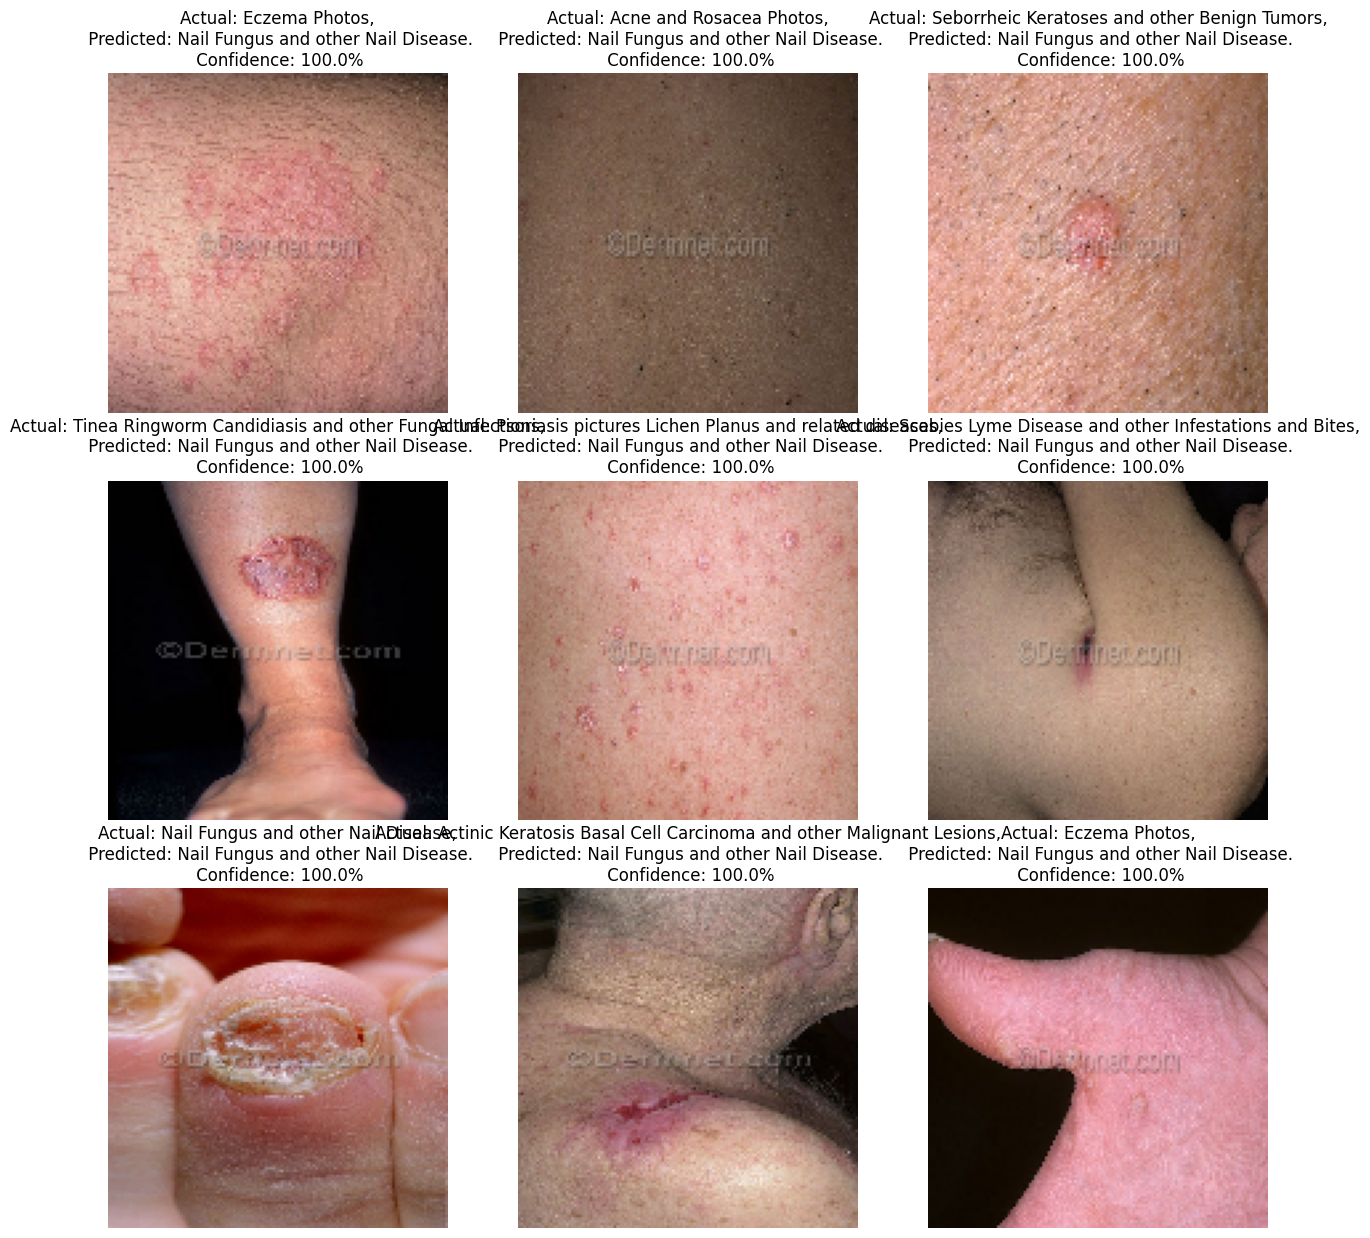

In [19]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Xception

In [7]:
from tensorflow.keras.applications import Xception
res = Xception(weights ='imagenet', include_top = False, 
               input_shape = (224, 224, 3)) 
               
# Setting the trainable to false
res.trainable = False


x= res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x) 
x = Dense(512, activation ='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation ='relu')(x)
x = BatchNormalization()(x)

x = Dense(23, activation ='softmax')(x)
model = Model(res.input, x)

model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),  #'Adam'
              loss ="categorical_crossentropy",  #sparse_categorical_crossentropy
              metrics =["categorical_accuracy"])  #sparse_categorical_accuracy

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [8]:
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [10]:
history = model.fit(train_df, 
                    epochs=50, 
                    validation_data=validation_df,
                   )

Epoch 1/50
195/195 [==============================] - 154s 788ms/step - loss: 1.7195 - categorical_accuracy: 0.4717 - val_loss: 3.0006 - val_categorical_accuracy: 0.2361
Epoch 2/50
195/195 [==============================] - 156s 800ms/step - loss: 1.6979 - categorical_accuracy: 0.4801 - val_loss: 2.9236 - val_categorical_accuracy: 0.2635
Epoch 3/50
195/195 [==============================] - 156s 799ms/step - loss: 1.6686 - categorical_accuracy: 0.4852 - val_loss: 2.9836 - val_categorical_accuracy: 0.2481
Epoch 4/50
195/195 [==============================] - 156s 798ms/step - loss: 1.6497 - categorical_accuracy: 0.4905 - val_loss: 2.9995 - val_categorical_accuracy: 0.2368
Epoch 5/50
195/195 [==============================] - 158s 811ms/step - loss: 1.6263 - categorical_accuracy: 0.5019 - val_loss: 2.9340 - val_categorical_accuracy: 0.2622
Epoch 6/50
195/195 [==============================] - 156s 798ms/step - loss: 1.6030 - categorical_accuracy: 0.5087 - val_loss: 3.0527 - val_categoric

In [11]:
model.save("./Xception/build")

INFO:tensorflow:Assets written to: ./Xception/build\assets


INFO:tensorflow:Assets written to: ./Xception/build\assets


## Using Inception ResNetV2

In [5]:
from tensorflow.keras.applications import InceptionResNetV2

In [6]:
res = InceptionResNetV2(weights ='imagenet', include_top = False, 
               input_shape = (224, 224, 3)) 
               
# Setting the trainable to false
res.trainable = False


x= res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x) 
x = Dense(512, activation ='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation ='relu')(x)
x = BatchNormalization()(x)

x = Dense(23, activation ='softmax')(x)
model = Model(res.input, x)

model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),  #'Adam'
              loss ="categorical_crossentropy",  #sparse_categorical_crossentropy
              metrics =["categorical_accuracy"])  #sparse_categorical_accuracy

# model.summary()

In [7]:
history = model.fit(train_df, 
                    epochs=10, 
                    validation_data=validation_df,
                   )

Epoch 1/10
195/195 [==============================] - 266s 1s/step - loss: 2.7055 - categorical_accuracy: 0.2433 - val_loss: 2.8517 - val_categorical_accuracy: 0.2168
Epoch 2/10
195/195 [==============================] - 156s 799ms/step - loss: 2.3279 - categorical_accuracy: 0.3108 - val_loss: 2.8520 - val_categorical_accuracy: 0.2117
Epoch 3/10
195/195 [==============================] - 155s 796ms/step - loss: 2.2002 - categorical_accuracy: 0.3390 - val_loss: 2.8213 - val_categorical_accuracy: 0.2407
Epoch 4/10
195/195 [==============================] - 156s 797ms/step - loss: 2.1173 - categorical_accuracy: 0.3650 - val_loss: 2.8348 - val_categorical_accuracy: 0.2300
Epoch 5/10
195/195 [==============================] - 155s 794ms/step - loss: 2.0631 - categorical_accuracy: 0.3757 - val_loss: 2.8316 - val_categorical_accuracy: 0.2284
Epoch 6/10
195/195 [==============================] - 157s 806ms/step - loss: 1.9981 - categorical_accuracy: 0.3910 - val_loss: 2.7856 - val_categorical_

## Using VGG19

In [11]:
from tensorflow.keras.applications import VGG19

In [12]:
res = VGG19(weights ='imagenet', include_top = False, 
               input_shape = (224, 224, 3)) 
               
# Setting the trainable to false
res.trainable = False


x= res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x) 
x = Dense(512, activation ='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation ='relu')(x)
x = BatchNormalization()(x)

x = Dense(23, activation ='softmax')(x)
model = Model(res.input, x)

model.compile(optimizer =tf.keras.optimizers.RMSprop(learning_rate=0.001),  #'Adam'
              loss ="categorical_crossentropy",  #sparse_categorical_crossentropy
              metrics =["categorical_accuracy"])  #sparse_categorical_accuracy

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [17]:
history = model.fit(train_df, 
                    epochs=50, 
                    validation_data=validation_df,
                    callbacks=[custom_early_stopping]
                   )

Epoch 1/50
195/195 [==============================] - 183s 901ms/step - loss: 2.8209 - categorical_accuracy: 0.2046 - val_loss: 2.9151 - val_categorical_accuracy: 0.1182
Epoch 2/50
195/195 [==============================] - 163s 835ms/step - loss: 2.5486 - categorical_accuracy: 0.2505 - val_loss: 2.7487 - val_categorical_accuracy: 0.1994
Epoch 3/50
195/195 [==============================] - 162s 828ms/step - loss: 2.4674 - categorical_accuracy: 0.2619 - val_loss: 2.8001 - val_categorical_accuracy: 0.1846
Epoch 4/50
195/195 [==============================] - 166s 850ms/step - loss: 2.4010 - categorical_accuracy: 0.2806 - val_loss: 2.8269 - val_categorical_accuracy: 0.2023
Epoch 5/50
195/195 [==============================] - 160s 823ms/step - loss: 2.3419 - categorical_accuracy: 0.2982 - val_loss: 2.7954 - val_categorical_accuracy: 0.2046
Epoch 6/50
195/195 [==============================] - 165s 846ms/step - loss: 2.3010 - categorical_accuracy: 0.3092 - val_loss: 2.8622 - val_categoric

## Loading and converting Xception model to tflite

In [8]:
model = tf.keras.models.load_model("./Xception/build")

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\tejas\AppData\Local\Temp\tmpcajv98hd\assets


INFO:tensorflow:Assets written to: C:\Users\tejas\AppData\Local\Temp\tmpcajv98hd\assets


In [10]:
with open('tflite_xception_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [12]:
train_data_gen.class_indices.items()

AttributeError: 'ImageDataGenerator' object has no attribute 'class_indices'